[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stefanlessmann/ESMT_IML/blob/main/notebooks/p3_classification.ipynb)

# Practical 3: Probability of default (PD) prediction and credit rating analysis
<hr>
In this practice session, we revisit the logistic regression model and study how it allows us to approach classification problems with two or more classes.

In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Binary classification for PD modeling
In the first part of the exercise, we come back to the credit risk prediction data set used in our [first session](https://github.com/stefanlessmann/ESMT_IML/blob/main/notebooks/p1_AI_peer_programming.ipynb) and also the demo of an [entire ML pipeline](https://github.com/stefanlessmann/ESMT_IML/blob/main/notebooks/p0_demo_ml_pipeline.ipynb).  

### Loading and preparing the data
We retrieve the data from GitHub.

In [2]:
data_location = 'https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/master/data/hmeq.csv'
df = pd.read_csv(data_location)  # standard pandas function to load tabular data in CSV format
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Recall the meaning of the features:
- BAD: the target variable, 1=default; 0=non-default
- LOAN: amount of the loan request
- MORTDUE: amount due on an existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

Here is a snapshot of the data.

In [3]:
df.head(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


The data requires at least a little bit of preparation to be ready for machine learning. First, we need to address the missing values. Second, two of the features, REASON and JOB, are non-numeric. Such categorical features cannot be used in a logistic regression model. We must convert them to numbers before using them. The following code addresses both problems in a quick but also simplistic way.

In [4]:
# Convert a category with k different values into k-1 binary variables. 
X = pd.get_dummies(df, dummy_na=True, drop_first=True)
X = X.dropna().reset_index(drop=True)  # drop all cases with one or more missing value

# Separate the data into a matrix of feature values and a target variable
y = X.pop('BAD')

### Excercise 1: Plotting data for classification
You will remember the many plots we came across when discussing regression. We also saw some analog plots for classification problems in the lecture. One of them was a 2d scatter plot displaying the bi-variate relationship between selected features and the binary target variable. 

![Classification problem in 2D](https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/2d_classification_problem.png)

Your first task is to create a similar plot for the credit data. In principle, you can select any combination of features that you like.  

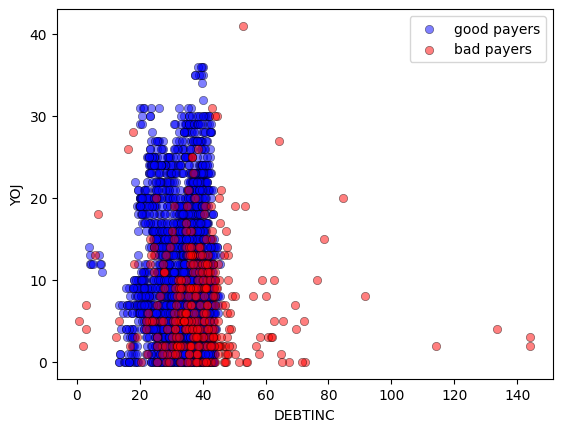

In [5]:
# Exercise 1
x1 = 'DEBTINC'  # select first feature of your choice
x2 = 'YOJ'  # select second feature of your choice

# Write code to create the scatter plot of x1 vs. x2. Make sure your plot shows the data points from different classes (good and bad payers) in different colors.
plt.scatter(X[y==0][x1], X[y==0][x2], c='blue', label="good payers", alpha=0.5, edgecolor="black", linewidth=0.5)
plt.scatter(X[y==1][x1], X[y==1][x2], c='red', label="bad payers", alpha=0.5, edgecolor="black", linewidth=0.5)
plt.legend(loc='best')
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

For the sake of completeness, the lecture also introduced a different 2D plot, in which we chart the target variable against one of the features. Provided you have made a choice above, by assigning variable `x1` some valid feature name, you will be able to execute the below code to create this type of plot.

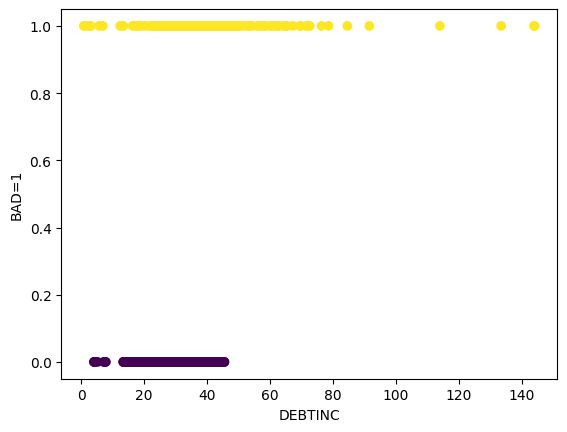

In [6]:
# Code to depict how the values of one feature, x1, distribute across the values of the target variable

# Just to make sure you did indeed a assign x1 a valid value ;)
assert x1 != '', "please assign a valid feature name to varible x2, like, e.g., x2='DEBTINC'"

# Plotting
plt.scatter(X[x1], y, c=y)
plt.xlabel(x1)
plt.ylabel('BAD=1')
plt.show()

Feel free to *play* with the above code and create the plot for several features. Note down some of your findings. The following questions can guide your thinking: 
- Will logistic regression work well with this data?
- Which feature appears to be most indicate of whether a credit applicant defaults or not?

### Excercise 2: Model adequacy  
We introduced logistic regression as an extension of linear regression for cases in which we work with a binary target variable. Nonetheless, just as linear regression, logistic regression is a linear model. It fits a line to the data.

Play with the above code to plot the distribution of different combinations of the features. Eventually, you should arrive at a preliminary conclusion of whether logistic regression is a suitable model for the data. 

**Do you think logistic regression is suitable for the data? Briefly explain your reasoning.**




**Also, has the analysis of different scatter plots revealed strong features that will facilitate predicting class membership (i.e., repayment behavior)?**





## Logistic regression
Time to estimate our first model. The below code uses the `sklearn` library to train a logistic regression classifier on the data. 

### Model training

In [7]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=888).fit(X, y)  # we define a random_state to ensure that we get the same results when re-running this cell multiple times
print(model)

LogisticRegression(random_state=888)


Note that the `sklearn` implementation does not provide an informative summary, as did the library `statsmodels` in our last practical. In brief, this is because `sklearn` is designed to support prediction. Let's demonstrate how to do this, that is compute predictions using the trained model. For simplicity, we compute prediction for the training data. Soon we will learn that this is actually inappropriate. Yet, we do it here to not overcomplicate things. 

In [8]:
yhat = model.predict(X)  # simply way to compute predictions using logistic regression and any other machine learning model in sklearn 

Likely, you are also interested to assess the model. There is an easy way to do this:

In [9]:
perf = model.score(X, y)  # Call a general purpose evaluation function and obtain a (quality ) score of the model
print('Logit model achieves a score of {:.3f} %'.format(perf*100))

Logit model achieves a score of 91.209 %


### Exercise 3: Diagnosing predictions
A score of above 90 percent sounds very good. Actually, it is not, and your task is to find out why. Let's break it down into pieces.

#### A) What score?
Check the sklearn documentation to understand what kind of score the function `score()` has provided. What is it that we see?

**Your answer:** By default, the score reported is the classification accuracy, which depends on a default classification cut-off of 0.5

#### B) Is it good or is it bad?
Interpreting our score will be easier if we compare it to a baseline. But what baseline? We face a classification problem. There are two classes, good payers and bad payers, and we aim to tell these apart. Come up with a very basic - naive - strategy to solve the classification problem without using any model. Write a piece of code to calculate the performance of your naive strategy. 
> Hint: if you feel a bit lost, consider web searching for *naive classifier* 

In [15]:
# Code to calculate the score of a naive classifier
pos_frac = np.sum(y==1)/len(y)  # share of the positive class, which typically represents the minority
print('A naive classifier, which always predicts the majority class, achieves classification accuracy equal to {:.2f}%'.format(100*(1-pos_frac)))

A naive classifier, which always predicts the majority class, achieves classification accuracy equal to 91.21%


This is a devasting result. Our logistic regression classifier is just as good as a naive classifier, which always predicts the majority class. Put differently, the logistic regression *appears* completely useless.

Note that our approach to compute the score of the naive classifier assumes that the positive class with $Y=1$ is the minority class. While is typically the case, we should acknowledge that your approach is simplistic. It would be preferrably to first establish which of the two classes is the majority class and to then use the fraction of that class as the accuracy score of a naive classifier. While not too difficult, we leave this extension for the interested to perform and move on with porbabilities. 

#### C) What about probabilities?
Exactly, what about probabilities? The lecture introduced logistic regression as a machine learning model that predicts class membership probabilities. So the model should answer questions such as "what is the estimated probability of the first credit applicant in our data set to repay?"

In [31]:
# Write code to print the prediction of logistic regression for the first data point in our matrix X
yhat = model.predict(X)
print(yhat[0])

0


Solving the above task, you will find that the prediction does not look like a probability. Examine this point in more detail. To that end, write code that tells you what distinct values logistic regression predict. Briefly explain what these values represent, what is their meaning.

In [32]:
# Code to find out the distinct values of the predictions
np.unique(yhat)

array([0], dtype=int64)

**What is the meaning of the predictions? Briefly explain.**

So the function `predict()` produces discrete class predictions. It outputs only the values with which the classes were encoded, that is either zero for class *good payer* or 1 for class *bad payer*. However, as shown using the function `numpy.unique()`, our logisitic regression only predicts class 0 and never predicts class 1.

Finally, we come back to the innocent question asked before, "what is the estimated probability of the first credit applicant in our data set to repay?". Given our previous analysis has not answered this question it is about time to. Write code to find out the estimated probability of the first applicant to be a bad credit risk?

Just in case, mathematically, we could represent the sought probability as $\hat{p}(BAD==1|X_1)$.

In [33]:
# Code to obtain probability predictions from the logit model
yhat_prob = model.predict_proba(X)
yhat_prob[0:5]

array([[0.75551234, 0.24448766],
       [0.73293697, 0.26706303],
       [0.7753799 , 0.2246201 ],
       [0.70491812, 0.29508188],
       [0.77890103, 0.22109897]])

### Visualizing the logistic regression
By now we have an intuition what stronger and weaker features the data set provides and how effective a logistic regression model is to classify repayment behavior when using all the features. 

#### Exercise 4: One more logistic regression
Please estimate a second logistic regression model. This time, use only two features. Exercise 1 has asked you to examine combinations of features. Just continue with the two features you selected there. 

In [37]:
print('Our first feature is:\t', x1)
print('Our second feature is:\t', x2)

Our first feature is:	 DEBTINC
Our second feature is:	 YOJ


In [38]:
# Write code to estimate a logistic regression classifier using only the two above features
model2 = LogisticRegression(random_state=888).fit(X[[x1, x2]], y)

#### The visual logistic regression
As you will have guessed, the point of the above exercise 4 was only to obtain a logistic regression model that we can plot; hence the need to select two features. 
The visualization is somewhat complex. Thus, all code is readily available for you. Below we provide a function `plot_logit_decision_surface()`. 
**Do not be put off by the length of the code.** You are not supposed to look through the function at this point. Of course, you are allowed to ;) but do not allow it to confuse you. It is a function to create a plot. That is all you need to know for now. Please execute the cell to make sure you can use the function in the next exercise. 

In [39]:
def plot_logit_decision_surface(model, data, x1, x2, save_fig=False):
    '''
        Visualization of logistic regression in 2D
        
        Creates a plot depicting the distribution of the input
        data along two dimensions and the probability predictions
        of a logistic regression model. 

        Parameters
        ----------
        model :   An instance of the sklearn class LogisticRegression,  which        
                  has been trained on the input data.

        data  :   Pandas data frame providing the feature values.

        x1, x2:   The function plots the results of logistic regression in
                  two dimensions. The parameters x1 and x2 give the names
                  of the features used for plotting. These features will be
                  extracted from the data frame.

        save_fig: Binary variable allowing you to save the figure as a PNG image. 
                  Default: False

        Returns
        ----------
        The function does not return a result. It's purpose is to visualize 
        logistic regression model. The corresponding plot is the only output.
    '''

    #if len(model.coef_.ravel())!=2:
    #    raise Exception('Please estimate a logit model using only two features!')
    # Define some variables to govern the plot
    bounds = data.describe().loc[["min", "max"]][[x1, x2]].to_numpy()  # value ranges of the two features
    eps = 5  # tolerance parameter 

    # Create hypothetical data points spanning the entire range of feature values.
    # We need these to get from our logistic regression model a probability prediction
    # for every possible data point
    xx, yy = np.mgrid[(bounds[0,0]-eps):(bounds[1,0]+eps), (bounds[0,1]-eps):(bounds[1,1]+eps)]
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Perhaps the logistic regression model was fitted using the full data frame. 
    # To also work in that case, we extract the estimated regression coefficients 
    # corresponding to the two features we consider for plotting
    feature_to_index = {name: idx for idx, name in enumerate(model.feature_names_in_)}  # create a dic as intermediate step
    indices = [feature_to_index[f] for f in [x1, x2]]  # Find the indices of our two features of interest using the dic
    w = model.coef_.ravel()[indices]  # estimated regression coefficients
    b = model.intercept_  # estimated intercept of the logistic regression model

    # Compute probability predictions over the entire space of possible feature values
    # In the interest of robustness, we manually compute the logistic regression predictions
    # using the regression coefficients extracted above
    probs = 1/(1+np.exp(-(np.dot(grid, w.reshape(2,-1))+b))).reshape(xx.shape)

    # We are finally ready to create our visualization
    f, ax = plt.subplots(figsize=(8, 6))  # new figure
    # Contour plot of the probability predictions across the entire feature range
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)  
    ax_c = f.colorbar(contour)
    ax_c.set_label("$\hat{p}(y=1|X)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    # Scatter plot of the actual data
    ax.scatter(data[x1], data[x2], c=y, s=50, cmap="RdBu", vmin=0, vmax=1,
               edgecolor="white", linewidth=1);
    plt.xlabel(x1)
    plt.ylabel(x2)
    if save_fig==True:
        plt.savefig('logit_contour.png')
    plt.show()

#### Exercise 5: Surface plot
We are almost ready. Also run the next cell, which will give you some instructions on how to use the plotting function. Note that this code also works for other functions. Just put a '?' in front of a function call and run the code. 

In [266]:
?plot_logit_decision_surface

Signature: plot_logit_decision_surface(model, data, x1='DEBTINC', x2='YOJ')
Docstring:
Visualization of logistic regression in 2D

Creates a plot depicting the distribution of the input
data along two dimensions and the probability predictions
of a logistic regression model. 

Parameters
----------
model : an instance of the sklearn class LogisticRegression,  which        
        has been trained on the input data.

data  : Pandas data frame providing the feature values.

x1, x2: The function plots the results of logistic regression in
        two dimensions. The parameters x1 and x2 give the names
        of the features used for plotting. These features will be
        extracted form the data frame.

Returns
----------
The function does not return a result. It's purpose is to visualize 
logistic regression model. The corresponding plot is the only output.
File:      c:\users\stefa\appdata\local\temp\ipykernel_17152\1247917285.py
Type:      function

I guess your next task is obvious. Write code to call the function providing the necessary parameters so that it can do its job. If used correctly, the function will create a plot like this one:
![Contour plot of logistic regression model](https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/logit_contour.png)

Let's if it works for you...

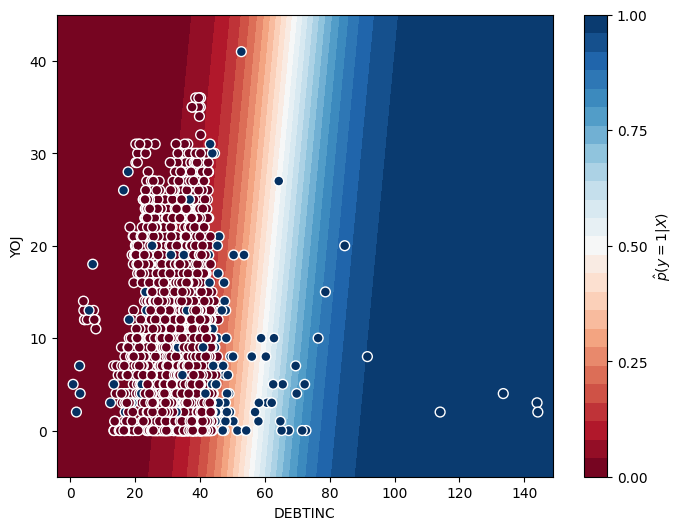

In [41]:
# Code to call the function plot_logit_decision_surface()
plot_logit_decision_surface(model2, X, x1, x2)

Finally, and hoping you got a nice contour plot of your logistic regression model, it is time to pause and think about the plot. It tells you a lot about how logistic regression works and the output you obtain. This is something we need to discuss in class. 

# Well done! This was another comprehensive set of exercises.